# Twitter Analysis
The purpose of the Twitter analysis is to identify

In [2]:
% reset -f

# Setup OAuth and access Twitter API in JSON format

import urllib, json, oauth2, re

def requestOAuth(query, size):
    CONSUMER_KEY = '1uONtpv9bUW3f5l74Uu4hx72d'
    CONSUMER_SECRET = 'vFT3cRx94KnuOquCzAmxWg4fgOzAAgukOSE92YOX8Tl6MPle7O'
    OAUTH_TOKEN = '769331309525274624-IE4AjwWlYNUaYhnNlL3sm5v1XnKoK6f'
    OAUTH_TOKEN_SECRET = 'rPVgeQBTGm5EBwksiEreRlgm8x4nJkTnWlf3nKIKCvFyi'    
    
    consumer = oauth2.Consumer(key=CONSUMER_KEY, secret=CONSUMER_SECRET)
    token = oauth2.Token(key=OAUTH_TOKEN, secret=OAUTH_TOKEN_SECRET)
    client = oauth2.Client(consumer, token)
    resp, content = client.request( "https://api.twitter.com/1.1/search/tweets.json?q=" + query + "&lang=en&result_type=recent&count=" + str(size), method="GET", body="", headers=None)
    return content

In [3]:
# Convert tweets to list of words (BOW).
# Treating retweets as individual tweets, as retweeting reflect people's believes

import itertools

# Search parameters
searchTerm = "Samsung"
tweetCount = 1000

searchContent = requestOAuth(searchTerm, tweetCount)
getContent = json.loads(searchContent)
        
allTweets = []
allWords = []
allTwitterHandles = set()

for getTexts in getContent['statuses']:
    # Getting raw tweets
    allTweets.append(getTexts['text'])
    
    # Removing links and convert to lowercase.
    removeLinks = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', getTexts['text'].lower().encode('utf8'), flags=re.MULTILINE)
    allWords.append(re.findall("\w+", removeLinks))
    
    # Getting mentioned Twitter handles
    for getNames in getTexts['entities']['user_mentions']:
        allTwitterHandles |= {getNames['screen_name']}

# Keep searchterm
allTwitterHandles.discard(searchTerm.lower())
        
wordList = list(itertools.chain(*allWords))
wordSet = set(list(itertools.chain(*allWords)))

print "Excerpt of all words:"
print wordList[0:10]
print
print "Excerpt of unique words:"
print list(wordSet)[0:10]
print
print "Twitter handles mentioned:"
print list(allTwitterHandles)

Excerpt of all words:
['rt', 'funbeaz', 'mega', 'giveaway', 'win', 'samsung', 's7', 'edge', 'all', 'you']

Excerpt of unique words:
['all', 'caused', 'month', 'follow', 'tv', 'tweet', 'flash', 'note5', 'to', 'ingredient']

Twitter handles mentioned:
[u'JihadiColin', u'funbeaz', u'OriginalOffers', u'DailyEbayDeal', u'AHSLadyGaga', u'Nells_Way', u'_eunyoungjeong', u'RepairManuals24', u'ArcanaLegacy', u'Monica61', u'RealDLHughley', u'SamsungMalaysia', u'EenL', u'nhancecanada', u'AlastairGale', u'michaelharrisdr', u'yhellothar', u'lailayuile', u'gsmarena_com', u'SamsungAU']


In [4]:
from collections import Counter

# Get word counts
freq = Counter(wordList)
getLen = len(wordList)
getSet = len(wordSet)

#print freq
print "Number of words:", getLen
print "Number of unique words:", getSet
print "Number of unique Twitter handles mentioned in tweets:", len(allTwitterHandles)


Number of words: 1485
Number of unique words: 584
Number of unique Twitter handles mentioned in tweets: 20


In [5]:
# Remove stopwords, numbers and words less than 2 characters long

import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer

LENGTH_OF_WORDS = 2

stopWords = set(stopwords.words('english'))
stopWords.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])
wordLem = WordNetLemmatizer()

# Use to remove twitter handles too
getWords = [wordLem.lemmatize(words) for words in wordList if words not in stopWords and words not in allTwitterHandles and words.isalpha() and len(words) > LENGTH_OF_WORDS]

# Use to keep twitter handles
#getWords = [wordLem.lemmatize(words) for words in wordList if words not in stopWords and words.isalpha() and len(words) > LENGTH_OF_WORDS]

getWordsSet = set(getWords)

print "All words, stripped:"
print getWords[0:10]
print
print "All unique words, stripped:"
print list(getWordsSet)[0:10]
print
print "Number of stripped words:", len(getWords)
print "Number of unique stripped words", len(getWordsSet)

All words, stripped:
['mega', 'giveaway', 'win', 'samsung', 'edge', 'like', 'retweet', 'follow', 'contest', u'end']

All unique words, stripped:
['caused', u'month', 'screen', 'follow', 'tweet', 'flash', u'spec', 'ingredient', 'smartphone', 'risk']

Number of stripped words: 868
Number of unique stripped words 406


In [46]:
totalDocsWithTerm = Counter()

for getTweet in allTweets:
    removeLinks = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', getTweet.lower().encode('utf8'), flags=re.MULTILINE)
    wordsInTweet = re.findall("\w+", removeLinks)
    getWordsTweets = [wordLem.lemmatize(words) for words in wordsInTweet if words not in stopWords and words not in allTwitterHandles and words.isalpha() and len(words) > LENGTH_OF_WORDS]
    
    for word in getWordsSet:
        if word in getWordsTweets:
            totalDocsWithTerm[word] += 1
        
print "Number of tweets that mention 'explosion':", totalDocsWithTerm['explosion']

Number of tweets that mention 'explosion': 3


In [32]:
# TF & IDF

import math
import operator

freqs = Counter(getWords)
getTF = {}
getIDF = {}
getTFIDF = {}

for get in getWordsSet:
    if len(get) > LENGTH_OF_WORDS:
        getTF[get] = freqs[get] / float(len(getWords))
        getIDF[get] = math.log(tweetCount / 1 + float(totalDocsWithTerm[get]))
        getTFIDF[get] = getTF[get] * getIDF[get]

print "TOP 10 TF:"
for key in sorted(getTF.items(), reverse=True, key=operator.itemgetter(1))[0:10]:
    print key[0] + ", " + str(key[1])

print
print "TOP 10 IDF:"
for key in sorted(getIDF.items(), reverse=True, key=operator.itemgetter(1))[0:10]:
    print key[0] + ", " + str(key[1])
    
print
print "TOP 10 TF-IDF:"
for key in sorted(getTFIDF.items(), reverse=True, key=operator.itemgetter(1))[0:10]:
    print key[0] + ", " + str(key[1])

TOP 10 TF:
samsung, 0.0910138248848
galaxy, 0.0460829493088
edge, 0.0184331797235
win, 0.0161290322581
december, 0.0115207373272
end, 0.0115207373272
giveaway, 0.0103686635945
follow, 0.00921658986175
sleeve, 0.00921658986175
retweet, 0.00921658986175

TOP 10 IDF:
samsung, 6.97728134163
galaxy, 6.94408720823
edge, 6.92362862814
win, 6.92165818415
december, 6.91770560984
end, 6.91770560984
giveaway, 6.91671502035
follow, 6.91572344863
sleeve, 6.91572344863
retweet, 6.91572344863

TOP 10 TF-IDF:
samsung, 0.635029062199
galaxy, 0.320004018812
edge, 0.127624490841
win, 0.111639648131
december, 0.0796970692377
end, 0.0796970692377
giveaway, 0.0717170912249
follow, 0.0637393866233
sleeve, 0.0637393866233
retweet, 0.0637393866233


In [33]:
# Convert wordlist to string. Words repeated based on their TFIDF score.

wordsString = ""
for key in getTFIDF:
    for weight in range(int(round(getTFIDF[key] * 100))):
        wordsString += key + " "
    #print key, getTFIDF[key]
    
print wordsString

caused caused month month screen screen follow follow follow follow follow follow tweet tweet flash flash spec spec ingredient smartphone smartphone smartphone risk risk infringement infringement automotive choice diary notesleeve fall cnet prize prize cable cable telfieapp team guy earbuds braid quicker htc htc htt design design download acid even even headset educate cell huawei waiting meizu new new tistheseason ever peoplecruelnowadays led led led led lee snowinvancouver snowinvancouver redeploy china acesse great lol sanfrancisco ceasefires auction auction involved lifeproof lifeproof blackmarino survey survey samsungmalaysia nylon via via apple apple win win win win win win win win win win win iph scandal usb usb working working finfet finfet live camera camera iphone iphone iphone iphone iphone iphone vehicle today today today today parliament parliament flas brings heir phone phone phone phone phone phone everywhere join hour car car work wallet wallet control earphone earphone

In [34]:
# Confirm wordStrings
getFinalWordCount = Counter(wordsString.split(" "))
for get in getFinalWordCount.most_common(20):
    print get

(u'samsung', 64)
(u'galaxy', 32)
(u'edge', 13)
(u'win', 11)
(u'december', 8)
(u'end', 8)
(u'giveaway', 7)
(u'follow', 6)
(u'iphone', 6)
(u'phone', 6)
(u'get', 6)
(u'note', 6)
(u'sleeve', 6)
(u'leather', 6)
(u'retweet', 6)
(u'mega', 6)
(u'amp', 6)
(u'like', 6)
(u'contest', 6)
(u'black', 5)


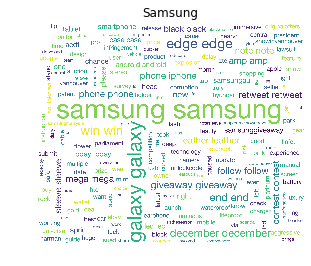

In [35]:
# Word cloud

from matplotlib import pyplot as plt
%matplotlib inline
#from scipy.misc import imread
from wordcloud import WordCloud
import numpy as np
from PIL import Image
from os import path

#getMask = np.array(Image.open(path.join("blankCanvas.png")))

#text = "test htx htc jyc jyc jyc jyc htc test samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung samsung"

getWC = WordCloud(font_path='HelveticaNeue.ttf', margin=10, width=1200, height=1000, scale=2, background_color="white", min_font_size=20)
getWC.generate(wordsString)
#getWC.generate(text)

getWC.to_file(path.join("wc.png"))

plt.title(searchTerm)
plt.imshow(getWC)
plt.axis("off")
plt.show()

# Sentiment analysis

In [10]:
#% reset -f

In [36]:
# Get happiness list
import requests as GET
sentimentDB = GET.get('http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0026752.s001')
print sentimentDB

<Response [200]>


In [37]:
import csv
import cStringIO
import pprint
from itertools import islice

labels = ('word', 'happiness_rank', 'happiness_average', 'happiness_standard_deviation', 'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank')

reader = csv.DictReader(cStringIO.StringIO(sentimentDB.text), delimiter = "\t", fieldnames = labels)
next(reader, None)
next(reader, None)
next(reader, None)

dictSentiment = {}

for line in reader:
    dictSentiment[line['word']] = line
    
#pprint.pprint(dictList[0:4])

getTop = list(islice(dictSentiment.iteritems(), 2))
pprint.pprint(getTop)

[('raining',
  {'google_rank': '--',
   'happiness_average': '5.92',
   'happiness_rank': '2949',
   'happiness_standard_deviation': '2.1650',
   'lyrics_rank': '2333',
   'nyt_rank': '--',
   'twitter_rank': '2007',
   'word': 'raining'}),
 ('writings',
  {'google_rank': '2608',
   'happiness_average': '6.12',
   'happiness_rank': '2239',
   'happiness_standard_deviation': '1.6964',
   'lyrics_rank': '--',
   'nyt_rank': '--',
   'twitter_rank': '--',
   'word': 'writings'})]


In [38]:
# Compute sentiment
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))
stopWords.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])

counter = 0
total = 0
score = 0
LENGTH_OF_WORDS = 2

keyList = [words.lower() for words in dictSentiment.keys() if words not in stopWords and words.isalpha() and len(words) > LENGTH_OF_WORDS]
print "Number of keys:", len(dictSentiment.keys())
print "Number of cleaned keys:", len(keyList)

Number of keys: 10222
Number of cleaned keys: 9518


In [39]:
# getWordsSet = All tweets combined into stripped wordlist (cleaned set)
for word in getWordsSet:
    if word in keyList:
        total += 1
        counter += float(dictSentiment[word]['happiness_average'])
    
    if total != 0:
        score = counter / total
    else:
        score = 0
        
print "Sentiment score on '" + searchTerm + "' based on " + str(tweetCount) + " tweets: " + str(score)

Sentiment score on 'Samsung' based on 1000 tweets: 5.756133829


In [40]:
import operator

# Get most negative words mentioned about searchterm
dictScore = {}
for word in getWordsSet:
    if word in keyList:
        dictScore[word] = dictSentiment[word]['happiness_average'], getFinalWordCount[word]

sortLowestScore = sorted(dictScore.items(), key=operator.itemgetter(1))
print "Top 10 words used in all tweets with lowest happiness score and wordcloud count:"
pprint.pprint(sortLowestScore[0:10])

print

print "Top 10 words used in all tweets with highest happiness score and wordcloud count:"
sortHighestScore = sorted(dictScore.items(), key=operator.itemgetter(1), reverse=True)
pprint.pprint(sortHighestScore[0:10])

Top 10 words used in all tweets with lowest happiness score and wordcloud count:
[('war', ('1.80', 1)),
 ('corruption', ('2.14', 2)),
 ('asshole', ('2.40', 1)),
 (u'explosion', ('2.94', 2)),
 ('lawsuit', ('2.96', 2)),
 ('forgotten', ('3.18', 1)),
 ('scandal', ('3.18', 1)),
 ('delay', ('3.38', 2)),
 ('acid', ('3.59', 1)),
 ('risk', ('3.62', 2))]

Top 10 words used in all tweets with highest happiness score and wordcloud count:
[('win', ('8.12', 11)),
 ('christmas', ('7.96', 1)),
 ('flower', ('7.88', 2)),
 ('great', ('7.88', 1)),
 ('success', ('7.86', 1)),
 ('entertainment', ('7.76', 1)),
 ('amazing', ('7.66', 1)),
 ('prize', ('7.62', 2)),
 ('awesome', ('7.60', 1)),
 ('gold', ('7.56', 2))]


In [41]:
# Are tweets more positive than negative?

avgPosScores = []
avgNegScores = []

posString = ""
negString = ""

# Get top half of highest scores (most positive)
for i in range(0, len(sortHighestScore)/2):   
    # Weighting taking into account
    avgPosScores.append(float(sortHighestScore[i][1][0]) * int(sortHighestScore[i][1][1]))
    
    # Generate string for wordcloud
    for j in range(int(sortHighestScore[i][1][1])):
        posString += sortHighestScore[i][0] + " "

# Get top half of lowest scores (most negative)
for i in range(0, len(sortLowestScore)/2):
    # Weighting taking into account
    avgNegScores.append(float(sortLowestScore[i][1][0]) * int(sortLowestScore[i][1][1]))

    # Generate string for wordcloud
    for j in range(int(sortLowestScore[i][1][1])):
        negString += sortLowestScore[i][0] + " "
    
print "Weighted average positive scores:", sum(avgPosScores)/float(len(avgPosScores))
print "Weighted average negative scores:", sum(avgNegScores)/float(len(avgNegScores))

Weighted average positive scores: 14.9269402985
Weighted average negative scores: 9.20731343284


Looks like the tweets are more positive than negative. Based on 'Samsung' searchterm.

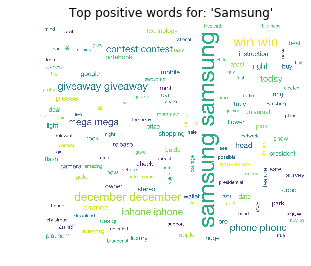

In [42]:
getWC.generate(posString)
#getWC.generate(text)

getWC.to_file(path.join("wcPositives.png"))

plt.title("Top positive words for: '" + searchTerm + "'")
plt.imshow(getWC)
plt.axis("off")
plt.show()

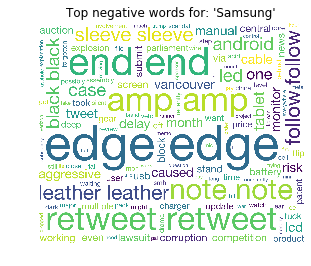

In [43]:
getWC.generate(negString)
#getWC.generate(text)

getWC.to_file(path.join("wcNegatives.png"))

plt.title("Top negative words for: '" + searchTerm + "'")
plt.imshow(getWC)
plt.axis("off")
plt.show()